# Process control files

Calculate drought metrics for control files, and regrid control files to 2° x 2°.

last updated/run on 28/01/2023

---

In [1]:
import sys
sys.path.append('../')  # import functions to make life easier
import climate_xr_funcs
import climate_droughts_xr_funcs

# import things
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cftime
import regionmask
import os
import geopandas as gp
import xesmf as xe
from dask.diagnostics import ProgressBar

from scipy import stats

# %% set file path to model output
filepath = '/Volumes/LaCie/CMIP5-PMIP3/CESM-LME/mon/PRECT_v6/'
filepath_pmip3 = '/Volumes/LaCie/CMIP5-PMIP3'

### Functions

In [ ]:
def save_netcdf_compression(ds, output_dir, filename):

    comp = dict(zlib=True, complevel=8)
    encoding = {var: comp for var in ds.data_vars}

    delayed_obj = ds.to_netcdf('%s/%s.nc' % (output_dir, filename), mode='w', compute=False, encoding=encoding)
    with ProgressBar():
        results = delayed_obj.compute()

In [22]:
def get_aus(ds):
    mask = regionmask.defined_regions.natural_earth.countries_110.mask(ds)
    ds_aus = ds.where(mask == 137, drop=True)
    return ds_aus

## Import files

In [4]:
bcc = xr.open_mfdataset('%s/piControl/pr/*_bcc-csm1-1_*.nc' % filepath_pmip3)
# bcc

In [5]:
ccsm4 = xr.open_mfdataset('%s/piControl/pr/*_CCSM4_*.nc' % filepath_pmip3)

In [6]:
csiro_mk3l = xr.open_mfdataset('%s/piControl/pr/*_CSIRO-Mk3L-1-2_*.nc' % filepath_pmip3)

In [7]:
fgoals_s2 = xr.open_mfdataset('%s/piControl/pr/*_FGOALS-s2_*.nc' % filepath_pmip3)

In [8]:
giss_2 = xr.open_mfdataset('%s/piControl/pr/*_GISS-E2-R_piControl_r1i1p2_*.nc' % filepath_pmip3)

In [3]:
giss_3 = xr.open_mfdataset('%s/piControl/pr/*_GISS-E2-R_piControl_r1i1p3_*.nc' % filepath_pmip3)

In [4]:
giss_1 = xr.open_mfdataset('%s/piControl/pr/*_GISS-E2-R_piControl_r1i1p1_*.nc' % filepath_pmip3)

In [5]:
giss_41 = xr.open_mfdataset('%s/piControl/pr/*_GISS-E2-R_piControl_r1i1p141_*.nc' % filepath_pmip3)

In [10]:
hadcm3 = xr.open_mfdataset('%s/piControl/pr/*_HadCM3_*.nc' % filepath_pmip3)

In [11]:
ipsl = xr.open_mfdataset('%s/piControl/pr/*_IPSL-CM5A-LR_*.nc' % filepath_pmip3)

In [12]:
miroc = xr.open_mfdataset('%s/piControl/pr/*_MIROC-ESM_*.nc' % filepath_pmip3)

/Users/nickywright/miniconda3/envs/py38-x86/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/nickywright/miniconda3/envs/py38-x86/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/nickywright/miniconda3/envs/py38-x86/lib/python3.8/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/Users/nicky

In [13]:
mpi = xr.open_mfdataset('%s/piControl/pr/*_MPI-ESM-P_*.nc' % filepath_pmip3, decode_times=False)
# fix times
# new_times = cftime.num2date(mpi.time.values, calendar='365_day', units='days since 850-01-01')
attrs = {'units': 'days since 850-01-01 00:00:00', 'calendar': '365_day'}
dates = xr.Dataset({'time': ('time', mpi.time.data, attrs)})
dates = xr.decode_cf(dates)
mpi['time'] = dates['time']

In [14]:
mri = xr.open_mfdataset('%s/piControl/pr/*_MRI-CGCM3_*.nc' % filepath_pmip3)

/Users/nickywright/miniconda3/envs/py38-x86/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/nickywright/miniconda3/envs/py38-x86/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/nickywright/miniconda3/envs/py38-x86/lib/python3.8/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


In [2]:
cesmlme = climate_xr_funcs.import_control_variable_cam(filepath, 'PRECT')
cesmlme

<xarray.Dataset>
Dimensions:   (time: 13872, lat: 96, lon: 144)
Coordinates:
  * time      (time) object 0850-01-16 00:00:00 ... 2005-12-16 00:00:00
  * lat       (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon       (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    PRECT     (time, lat, lon) float32 dask.array<chunksize=(100, 96, 144), meta=np.ndarray>
    PRECT_mm  (time, lat, lon) float64 dask.array<chunksize=(100, 96, 144), meta=np.ndarray>
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             b.e11.B1850C5CN.f19_g16.0850cntl.001
    title:            UNSET
    logname:          nanr
    host:             ys1256
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     b.e11.B1850C5CN.f19_g16.008.cam.i.0651-01-01-00000.nc
    topography_file:  /glade/p/cesm/cseg//inputdata/atm/cam/topo/consistent-t...

In [19]:
fgoals_gl = xr.open_mfdataset('%s/piControl/pr/*_FGOALS-g2_*.nc' % filepath_pmip3)

/Users/nickywright/miniconda3/envs/py38-x86/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/nickywright/miniconda3/envs/py38-x86/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'pr_var' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [20]:
fgoals_gl

<xarray.Dataset>
Dimensions:           (time: 8412, lon: 128, bnds: 2, lat: 60)
Coordinates:
  * time              (time) object 0001-01-16 12:00:00 ... 0900-12-16 12:00:00
  * lon               (lon) float64 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * lat               (lat) float64 -90.0 -83.87 -79.15 ... 79.15 83.87 90.0
Dimensions without coordinates: bnds
Data variables:
    lon_bnds          (lon, bnds, time) float64 dask.array<chunksize=(128, 2, 132), meta=np.ndarray>
    lat_bnds          (lat, bnds, time) float64 dask.array<chunksize=(60, 2, 132), meta=np.ndarray>
    pr                (time, lat, lon) float32 dask.array<chunksize=(132, 60, 128), meta=np.ndarray>
    pr_var            (time, lat, lon) float32 dask.array<chunksize=(8412, 60, 128), meta=np.ndarray>
    climatology_bnds  (time, bnds) float64 dask.array<chunksize=(8412, 2), meta=np.ndarray>
    time_bnds         (time, bnds) object dask.array<chunksize=(132, 2), meta=np.ndarray>
Attributes: (12/30)
    Conventions:            CF-1.4
    source:                 FGOALS_g2 2011 atmosphere: GAMIL (gamil2, 128x60L...
    institution:            IAP (Institute of Atmospheric Physics, Chinese Ac...
    institute_id:           LASG-CESS
    experiment_id:          piControl
    model_id:               FGOALS_g2
    ...                     ...
    modeling_realm:         atmos
    realization:            1
    cmor_version:           2.7.1
    version_history:        v1
    history:                2014-03-12T11:48:34Z Climatological monthly mean ...
    tracking_history:       [['pr_Amon_FGOALS-g2_piControl_r1i1p1_000101-0010...

### convert precip into annual

In [6]:
def convert_pmip3_pr_annual(ds):
    month_length = xr.DataArray(climate_xr_funcs.get_dpm(ds.pr, calendar='noleap'), coords=[ds.pr.time], name='month_length')
    ds['PRECT_mm'] = ds.pr * 60 * 60 * 24 * month_length # to be in mm/month first
    ds_annual = ds.groupby('time.year').sum('time', skipna=False)
    return ds_annual

In [16]:
bcc_annual = convert_pmip3_pr_annual(bcc)
ccsm4_annual = convert_pmip3_pr_annual(ccsm4)
csiro_mk3l_annual = convert_pmip3_pr_annual(csiro_mk3l)
fgoals_s2_annual = convert_pmip3_pr_annual(fgoals_s2)
giss_2_annual = convert_pmip3_pr_annual(giss_2)
hadcm3_annual = convert_pmip3_pr_annual(hadcm3)
ipsl_annual = convert_pmip3_pr_annual(ipsl)
miroc_annaul = convert_pmip3_pr_annual(miroc)
mpi_annual = convert_pmip3_pr_annual(mpi)
mri_annual = convert_pmip3_pr_annual(mri)

In [7]:
giss_3_annual = convert_pmip3_pr_annual(giss_3)
giss_1_annual = convert_pmip3_pr_annual(giss_1)
giss_41_annual = convert_pmip3_pr_annual(giss_41)

In [23]:
fgoals_gl_annual = convert_pmip3_pr_annual(fgoals_gl)

In [17]:
cesmlme_annual = cesmlme.groupby('time.year').sum('time', skipna=False)

## calculate drought metrics

In [8]:
def drought_metrics(ds,  output_dir, model_filename):
    print('... Calculating drought metrics for %s' % (model_filename))
    # stats are calculated relative to the long term mean
    
    # get years that are drought vs not drought
    ds['drought_years_2s2e']       = climate_droughts_xr_funcs.get_drought_years_2S2E_apply(ds.PRECT_mm, ds.PRECT_mm.mean(dim='year'))
    ds['drought_years_median']     = climate_droughts_xr_funcs.get_drought_years_below_threshold_apply(ds.PRECT_mm, ds.PRECT_mm.quantile(0.5, dim=('year')))
    ds['drought_years_20perc']     = climate_droughts_xr_funcs.get_drought_years_below_threshold_apply(ds.PRECT_mm, ds.PRECT_mm.quantile(0.2, dim=('year')))
    ds['drought_years_120pc_2med'] = climate_droughts_xr_funcs.get_drought_years_120perc_2median_apply(ds.PRECT_mm, ds.PRECT_mm.quantile(0.2, dim='year'), ds.PRECT_mm.quantile(0.5, dim='year'))
    ds['drought_years_220pc_1med'] = climate_droughts_xr_funcs.get_drought_years_start_end_thresholds_apply(ds.PRECT_mm, ds.PRECT_mm.quantile(0.2, dim=('year')), ds.PRECT_mm.quantile(0.5, dim=('year')))
    
    print('... Calculated drought years')
    # get overall length of droughts
    ds['droughts_2s2e']       = climate_droughts_xr_funcs.cumulative_drought_length(ds['drought_years_2s2e'])
    ds['droughts_median']     = climate_droughts_xr_funcs.cumulative_drought_length(ds['drought_years_median'])
    ds['droughts_20perc']     = climate_droughts_xr_funcs.cumulative_drought_length(ds['drought_years_20perc'])
    ds['droughts_120pc_2med'] = climate_droughts_xr_funcs.cumulative_drought_length(ds['drought_years_120pc_2med'])
    ds['droughts_220pc_1med'] = climate_droughts_xr_funcs.cumulative_drought_length(ds['drought_years_220pc_1med'])
    
    print('... Calculated length of drought')
        
    # get max length in this period
    ds['droughts_2s2e_max']       = climate_droughts_xr_funcs.max_length_ufunc(ds.droughts_2s2e, dim='year')
    ds['droughts_median_max']     = climate_droughts_xr_funcs.max_length_ufunc(ds.droughts_median, dim='year')
    ds['droughts_20perc_max']     = climate_droughts_xr_funcs.max_length_ufunc(ds.droughts_20perc, dim='year')
    ds['droughts_120pc_2med_max'] = climate_droughts_xr_funcs.max_length_ufunc(ds.droughts_120pc_2med, dim='year')
    ds['droughts_220pc_1med_max'] = climate_droughts_xr_funcs.max_length_ufunc(ds.droughts_220pc_1med, dim='year')

    print('... Calculated max length of drought')
        
    # get mean length in this period
    ds['droughts_2s2e_mean']       = climate_droughts_xr_funcs.mean_length_ufunc(ds.droughts_2s2e, dim='year')
    ds['droughts_median_mean']     = climate_droughts_xr_funcs.mean_length_ufunc(ds.droughts_median, dim='year')
    ds['droughts_20perc_mean']     = climate_droughts_xr_funcs.mean_length_ufunc(ds.droughts_20perc, dim='year')
    ds['droughts_120pc_2med_mean'] = climate_droughts_xr_funcs.mean_length_ufunc(ds.droughts_120pc_2med, dim='year')
    ds['droughts_220pc_1med_mean'] = climate_droughts_xr_funcs.mean_length_ufunc(ds.droughts_220pc_1med, dim='year')

    print('... Calculated mean length of drought')
        
    # count how many individual events occur
    ds['droughts_2s2e_no_of_events']       = climate_droughts_xr_funcs.count_drought_events_apply(ds.droughts_2s2e)
    ds['droughts_median_no_of_events']     = climate_droughts_xr_funcs.count_drought_events_apply(ds.droughts_median)
    ds['droughts_20perc_no_of_events']     = climate_droughts_xr_funcs.count_drought_events_apply(ds.droughts_20perc)
    ds['droughts_120pc_2med_no_of_events'] = climate_droughts_xr_funcs.count_drought_events_apply(ds.droughts_120pc_2med)
    ds['droughts_220pc_1med_no_of_events'] = climate_droughts_xr_funcs.count_drought_events_apply(ds.droughts_220pc_1med)
    
    print('... Counted number of drought events')
    # std
    ds['droughts_2s2e_std']       = climate_droughts_xr_funcs.std_apply(ds.droughts_2s2e, dim='year')
    ds['droughts_median_std']     = climate_droughts_xr_funcs.std_apply(ds.droughts_median, dim='year')
    ds['droughts_20perc_std']     = climate_droughts_xr_funcs.std_apply(ds.droughts_20perc, dim='year')
    ds['droughts_120pc_2med_std'] = climate_droughts_xr_funcs.std_apply(ds.droughts_120pc_2med, dim='year')
    ds['droughts_220pc_1med_std'] = climate_droughts_xr_funcs.std_apply(ds.droughts_220pc_1med, dim='year')
    
    print('... Calculated drought std')
        
    # intensity  - relative to climatological mean (same as in anna's paper)
    ds['droughts_2s2e_intensity']        = climate_droughts_xr_funcs.drought_intensity(ds, 'drought_years_2s2e', 'droughts_2s2e', ds.PRECT_mm.mean(dim='year'))
    ds['droughts_median_intensity']      = climate_droughts_xr_funcs.drought_intensity(ds, 'drought_years_median', 'droughts_median', ds.PRECT_mm.mean(dim='year'))
    ds['droughts_20perc_intensity']      = climate_droughts_xr_funcs.drought_intensity(ds, 'drought_years_20perc', 'droughts_20perc', ds.PRECT_mm.mean(dim='year'))
    ds['droughts_120pc_2med_intensity'] = climate_droughts_xr_funcs.drought_intensity(ds, 'drought_years_120pc_2med', 'droughts_120pc_2med', ds.PRECT_mm.mean(dim='year'))
    ds['droughts_220pc_1med_intensity'] = climate_droughts_xr_funcs.drought_intensity(ds, 'drought_years_220pc_1med', 'droughts_220pc_1med', ds.PRECT_mm.mean(dim='year'))
    
    print('... Calculated drought intensity')
    
    # severity - intensity x length
    ds['droughts_2s2e_severity']        = climate_droughts_xr_funcs.drought_severity(ds, 'drought_years_2s2e', 'droughts_2s2e', ds.PRECT_mm.mean(dim='year'))
    ds['droughts_median_severity']      = climate_droughts_xr_funcs.drought_severity(ds, 'drought_years_median', 'droughts_median', ds.PRECT_mm.mean(dim='year'))
    ds['droughts_20perc_severity']      = climate_droughts_xr_funcs.drought_severity(ds, 'drought_years_20perc', 'droughts_20perc', ds.PRECT_mm.mean(dim='year'))
    ds['droughts_120pc_2med_severity'] = climate_droughts_xr_funcs.drought_severity(ds, 'drought_years_120pc_2med', 'droughts_120pc_2med', ds.PRECT_mm.mean(dim='year'))
    ds['droughts_220pc_1med_severity'] = climate_droughts_xr_funcs.drought_severity(ds, 'drought_years_220pc_1med', 'droughts_220pc_1med', ds.PRECT_mm.mean(dim='year'))
    
    print('... Calculated drought severity')
    
    ds['droughts_2s2e_no_events_100yrs'] = (ds.droughts_2s2e_no_of_events / len(ds.year)) * 100
    ds['droughts_2s2e_sum'] = climate_droughts_xr_funcs.sum_apply(ds.droughts_2s2e, dim='year') 
    ds['droughts_2s2e_sum_100yrs'] = climate_droughts_xr_funcs.sum_apply(ds.droughts_2s2e, dim='year') / len(ds.year) * 100
    
    # get rid of quantile
    ds = ds.drop('quantile')
    
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
        
    print('... Saving %s last millennium file to:  %s' % (model_filename, output_dir))
    comp = dict(zlib=True, complevel=8)
    encoding = {var: comp for var in ds.data_vars}
    
    delayed_obj = ds.to_netcdf('%s/%s_precip_cntl_annual.nc' % (output_dir, model_filename), compute=False, encoding=encoding)
    with ProgressBar():
        results = delayed_obj.compute()
    
    return ds

In [9]:
def droughts_metrics_timeseries(ds):
    
    ds2 = ds.PRECT_mm
    ds3 = ds2.to_dataset()
#     print(ds2)
    ff_precip_annual = ds3

    # get years that are drought vs not drought
    ff_precip_annual['drought_years_2s2e'] = climate_droughts_xr_funcs.get_drought_years_2S2E(ff_precip_annual.PRECT_mm, ff_precip_annual.PRECT_mm.mean(dim='year'))
    ff_precip_annual['drought_years_median'] = ('year', climate_droughts_xr_funcs.get_drought_years_below_threshold(ff_precip_annual.PRECT_mm, ff_precip_annual.PRECT_mm.quantile(0.5, dim='year')))
    ff_precip_annual['drought_years_20perc'] = ('year', climate_droughts_xr_funcs.get_drought_years_below_threshold(ff_precip_annual.PRECT_mm, ff_precip_annual.PRECT_mm.quantile(0.2, dim='year')))
    ff_precip_annual['drought_years_120pc_2med'] = ('year', climate_droughts_xr_funcs.get_drought_years_120perc_2median(ff_precip_annual.PRECT_mm, ff_precip_annual.PRECT_mm.quantile(0.2, dim='year'), ff_precip_annual.PRECT_mm.quantile(0.5, dim='year')))
    ff_precip_annual['drought_years_220pc_1med'] = ('year', climate_droughts_xr_funcs.get_drought_years_below_start_end_thresholds(ff_precip_annual.PRECT_mm, ff_precip_annual.PRECT_mm.quantile(0.2, dim='year'), ff_precip_annual.PRECT_mm.quantile(0.5, dim='year')))

    # get overall length of droughts
    ff_precip_annual['droughts_2s2e'] = climate_droughts_xr_funcs.cumulative_drought_length(ff_precip_annual['drought_years_2s2e'])
    ff_precip_annual['droughts_median'] = climate_droughts_xr_funcs.cumulative_drought_length(ff_precip_annual['drought_years_median'])
    ff_precip_annual['droughts_20perc'] = climate_droughts_xr_funcs.cumulative_drought_length(ff_precip_annual['drought_years_20perc'])
    ff_precip_annual['droughts_120pc_2med'] = climate_droughts_xr_funcs.cumulative_drought_length(ff_precip_annual['drought_years_120pc_2med'])
    ff_precip_annual['droughts_220pc_1med'] = climate_droughts_xr_funcs.cumulative_drought_length(ff_precip_annual['drought_years_220pc_1med'])
    
    # get max length in this period
    ff_precip_annual['droughts_2s2e_max'] = climate_droughts_xr_funcs.max_length_ufunc(ff_precip_annual.droughts_2s2e, dim='year')
    ff_precip_annual['droughts_median_max'] = climate_droughts_xr_funcs.max_length_ufunc(ff_precip_annual.droughts_median, dim='year')
    ff_precip_annual['droughts_20perc_max'] = climate_droughts_xr_funcs.max_length_ufunc(ff_precip_annual.droughts_20perc, dim='year')
    ff_precip_annual['droughts_120pc_2med_max'] = climate_droughts_xr_funcs.max_length_ufunc(ff_precip_annual.droughts_120pc_2med, dim='year')
    ff_precip_annual['droughts_220pc_1med_max'] = climate_droughts_xr_funcs.max_length_ufunc(ff_precip_annual.droughts_220pc_1med, dim='year')
    
    # get mean length in this period
    ff_precip_annual['droughts_2s2e_mean'] = climate_droughts_xr_funcs.mean_length_ufunc(ff_precip_annual.droughts_2s2e, dim='year')
    ff_precip_annual['droughts_median_mean'] = climate_droughts_xr_funcs.mean_length_ufunc(ff_precip_annual.droughts_median, dim='year')
    ff_precip_annual['droughts_20perc_mean'] = climate_droughts_xr_funcs.mean_length_ufunc(ff_precip_annual.droughts_20perc, dim='year')
    ff_precip_annual['droughts_120pc_2med_mean'] = climate_droughts_xr_funcs.mean_length_ufunc(ff_precip_annual.droughts_120pc_2med, dim='year')
    ff_precip_annual['droughts_220pc_1med_mean'] = climate_droughts_xr_funcs.mean_length_ufunc(ff_precip_annual.droughts_220pc_1med, dim='year')
    
    # count how many individual events occur
    ff_precip_annual['droughts_2s2e_no_of_events'] = climate_droughts_xr_funcs.count_drought_events(ff_precip_annual.droughts_2s2e)
    ff_precip_annual['droughts_median_no_of_events'] = climate_droughts_xr_funcs.count_drought_events(ff_precip_annual.droughts_median)
    ff_precip_annual['droughts_20perc_no_of_events'] = climate_droughts_xr_funcs.count_drought_events(ff_precip_annual.droughts_20perc)
    ff_precip_annual['droughts_120pc_2med_no_of_events'] = climate_droughts_xr_funcs.count_drought_events(ff_precip_annual.droughts_120pc_2med)
    ff_precip_annual['droughts_220pc_1med_no_of_events'] = climate_droughts_xr_funcs.count_drought_events(ff_precip_annual.droughts_220pc_1med)
    
    ff_precip_annual['droughts_2s2e_std'] = climate_droughts_xr_funcs.std_apply(ff_precip_annual.droughts_2s2e, dim='year')
    ff_precip_annual['droughts_median_std'] = climate_droughts_xr_funcs.std_apply(ff_precip_annual.droughts_median, dim='year')
    ff_precip_annual['droughts_20perc_std'] = climate_droughts_xr_funcs.std_apply(ff_precip_annual.droughts_20perc, dim='year')
    ff_precip_annual['droughts_120pc_2med_std'] = climate_droughts_xr_funcs.std_apply(ff_precip_annual.droughts_120pc_2med, dim='year')
    ff_precip_annual['droughts_220pc_1med_std'] = climate_droughts_xr_funcs.std_apply(ff_precip_annual.droughts_220pc_1med, dim='year')
    
    ff_precip_annual['droughts_2s2e_intensity'] = climate_droughts_xr_funcs.drought_intensity(ff_precip_annual, 'drought_years_2s2e', 'droughts_2s2e', ff_precip_annual.PRECT_mm.mean(dim='year'))
    ff_precip_annual['droughts_median_intensity'] = climate_droughts_xr_funcs.drought_intensity(ff_precip_annual, 'drought_years_median', 'droughts_median', ff_precip_annual.PRECT_mm.mean(dim='year'))
    ff_precip_annual['droughts_20perc_intensity'] = climate_droughts_xr_funcs.drought_intensity(ff_precip_annual, 'drought_years_20perc', 'droughts_20perc', ff_precip_annual.PRECT_mm.mean(dim='year'))
    ff_precip_annual['droughts_120pc_2med_intensity'] = climate_droughts_xr_funcs.drought_intensity(ff_precip_annual, 'drought_years_120pc_2med', 'droughts_120pc_2med', ff_precip_annual.PRECT_mm.mean(dim='year'))
    ff_precip_annual['droughts_220pc_1med_intensity'] = climate_droughts_xr_funcs.drought_intensity(ff_precip_annual, 'drought_years_220pc_1med', 'droughts_220pc_1med', ff_precip_annual.PRECT_mm.mean(dim='year'))

    ff_precip_annual['droughts_2s2e_severity'] = climate_droughts_xr_funcs.drought_severity(ff_precip_annual, 'drought_years_2s2e', 'droughts_2s2e', ff_precip_annual.PRECT_mm.mean(dim='year'))
    ff_precip_annual['droughts_median_severity'] = climate_droughts_xr_funcs.drought_severity(ff_precip_annual, 'drought_years_median', 'droughts_median', ff_precip_annual.PRECT_mm.mean(dim='year'))
    ff_precip_annual['droughts_20perc_severity'] = climate_droughts_xr_funcs.drought_severity(ff_precip_annual, 'drought_years_20perc', 'droughts_20perc', ff_precip_annual.PRECT_mm.mean(dim='year'))
    ff_precip_annual['droughts_120pc_2med_severity'] = climate_droughts_xr_funcs.drought_severity(ff_precip_annual, 'drought_years_120pc_2med', 'droughts_120pc_2med', ff_precip_annual.PRECT_mm.mean(dim='year'))
    ff_precip_annual['droughts_220pc_1med_severity'] = climate_droughts_xr_funcs.drought_severity(ff_precip_annual, 'drought_years_220pc_1med', 'droughts_220pc_1med', ff_precip_annual.PRECT_mm.mean(dim='year'))
    
    return ff_precip_annual



In [26]:
bcc_annual.load()
ccsm4_annual.load()
csiro_mk3l_annual.load()
fgoals_s2_annual.load()
giss_2_annual.load()
giss_3_annual.load()
hadcm3_annual.load()
ipsl_annual.load()
miroc_annaul.load()
mpi_annual.load()
mri_annual.load()

<xarray.Dataset>
Dimensions:   (lat: 160, year: 500, bnds: 2, lon: 320)
Coordinates:
  * lat       (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon       (lon) float64 0.0 1.125 2.25 3.375 4.5 ... 355.5 356.6 357.8 358.9
  * year      (year) int64 1851 1852 1853 1854 1855 ... 2346 2347 2348 2349 2350
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (year, lat, bnds) float64 -90.0 -88.59 -88.59 ... 88.59 88.59 90.0
    lon_bnds  (year, lon, bnds) float64 -0.5625 0.5625 0.5625 ... 358.3 359.4
    pr        (year, lat, lon) float32 3.598e-05 3.602e-05 ... 8.42e-05
    PRECT_mm  (year, lat, lon) float64 94.13 94.22 93.9 ... 222.0 223.7 222.0

In [10]:
giss_3_annual.load()
giss_1_annual.load()
giss_41_annual.load()

<xarray.Dataset>
Dimensions:   (lat: 90, year: 1163, bnds: 2, lon: 144)
Coordinates:
  * lat       (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon       (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * year      (year) int64 850 851 852 853 854 855 ... 2008 2009 2010 2011 2012
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (year, lat, bnds) float64 -1.08e+03 -1.056e+03 ... 1.08e+03
    lon_bnds  (year, lon, bnds) float64 0.0 30.0 30.0 ... 4.29e+03 4.32e+03
    pr        (year, lat, lon) float32 6.774e-06 6.774e-06 ... 3.495e-05
    PRECT_mm  (year, lat, lon) float64 17.84 17.84 17.84 ... 91.92 91.92 91.92

In [23]:
output_dir = '../files/control'

In [31]:
# bcc_annual_cntl        = drought_metrics(bcc_annual,  output_dir, 'bcc')
ccsm4_annual_cntl      = drought_metrics(ccsm4_annual, output_dir, 'ccsm4')
csiro_mk3l_annual_cntl = drought_metrics(csiro_mk3l_annual, output_dir, 'csiro_mk3l')
fgoals_s2_annual_cntl  = drought_metrics(fgoals_s2_annual, output_dir, 'fgoals_s2')
giss_2_annual_cntl     = drought_metrics(giss_2_annual, output_dir, 'giss_2')
hadcm3_annual_cntl     = drought_metrics(hadcm3_annual, output_dir, 'hadcm3')
ipsl_annual_cntl       = drought_metrics(ipsl_annual, output_dir, 'ipsl')
miroc_annaul_cntl      = drought_metrics(miroc_annaul, output_dir, 'miroc')
mpi_annual_cntl        = drought_metrics(mpi_annual, output_dir, 'mpi')
mri_annual_cntl        = drought_metrics(mri_annual, output_dir, 'mri')

... Calculating drought metrics for ccsm4
... Calculated drought years
... Calculated length of drought
... Calculated max length of drought
... Calculated mean length of drought
... Counted number of drought events
... Calculated drought std
... Calculated drought intensity
... Calculated drought severity
... Saving ccsm4 last millennium file to:  ../files/control
[########################################] | 100% Completed |  0.2s
... Calculating drought metrics for csiro_mk3l
... Calculated drought years
... Calculated length of drought
... Calculated max length of drought
... Calculated mean length of drought
... Counted number of drought events
... Calculated drought std
... Calculated drought intensity
... Calculated drought severity
... Saving csiro_mk3l last millennium file to:  ../files/control
[########################################] | 100% Completed |  0.1s
... Calculating drought metrics for fgoals_s2
... Calculated drought years
... Calculated length of drought
... Calcul

In [32]:
cesmlme_annual.load()
cesmlme_annual_cntl        = drought_metrics(cesmlme_annual, output_dir, 'cesmlme')

... Calculating drought metrics for cesmlme
... Calculated drought years
... Calculated length of drought
... Calculated max length of drought
... Calculated mean length of drought
... Counted number of drought events
... Calculated drought std
... Calculated drought intensity
... Calculated drought severity
... Saving cesmlme last millennium file to:  ../files/control
[########################################] | 100% Completed |  0.1s


In [13]:
# giss_3_annual_cntl     = drought_metrics(giss_3_annual, output_dir, 'giss_3')
# giss_1_annual_cntl     = drought_metrics(giss_1_annual, output_dir, 'giss_1')
giss_41_annual_cntl     = drought_metrics(giss_41_annual, output_dir, 'giss_41')

... Calculating drought metrics for giss_41
... Calculated drought years
... Calculated length of drought
... Calculated max length of drought
... Calculated mean length of drought
... Counted number of drought events
... Calculated drought std
... Calculated drought intensity
... Calculated drought severity
... Saving giss_41 last millennium file to:  ../files/control
[                                        ] | 0% Completed |  0.0s

IOStream.flush timed out
IOStream.flush timed out


[########################################] | 100% Completed |  0.1s


In [26]:
giss_1_annual_cntl = xr.open_dataset('%s/giss_1_precip_cntl_annual.nc' % output_dir)
giss_3_annual_cntl = xr.open_dataset('%s/giss_3_precip_cntl_annual.nc' % output_dir)

## get australia

In [34]:
bcc_annual_cntl_aus = get_aus(bcc_annual_cntl)              
ccsm4_annual_cntl_aus = get_aus(ccsm4_annual_cntl)          
csiro_mk3l_annual_cntl_aus = get_aus(csiro_mk3l_annual_cntl)
fgoals_s2_annual_cntl_aus = get_aus(fgoals_s2_annual_cntl)  
giss_2_annual_cntl_aus = get_aus(giss_2_annual_cntl)        
hadcm3_annual_cntl_aus = get_aus(hadcm3_annual_cntl)        
ipsl_annual_cntl_aus = get_aus(ipsl_annual_cntl)            
miroc_annaul_cntl_aus = get_aus(miroc_annaul_cntl)          
mpi_annual_cntl_aus = get_aus(mpi_annual_cntl)              
mri_annual_cntl_aus = get_aus(mri_annual_cntl)              

/Users/nickywright/miniconda3/envs/py38-x86/lib/python3.8/site-packages/regionmask/defined_regions/_natural_earth.py:471: FutureWarning: ``regionmask.defined_regions.natural_earth`` is deprecated. Please use ``regionmask.defined_regions.natural_earth_v4_1_0`` or ``regionmask.defined_regions.natural_earth_v5_0_0`` instead.
  warnings.warn(


In [35]:
cesmlme_annual_cntl_aus = get_aus(cesmlme_annual_cntl)
save_netcdf_compression(cesmlme_annual_cntl_aus, output_dir, 'cesmlme_precip_cntl_annual_aus')

[########################################] | 100% Completed |  0.1s


In [36]:
cesmlme_annual_cntl_aus

<xarray.Dataset>
Dimensions:                           (year: 1156, lat: 15, lon: 16)
Coordinates:
  * lat                               (lat) float64 -42.63 -36.95 ... -12.32
  * lon                               (lon) float64 115.0 117.5 ... 150.0 152.5
  * year                              (year) int64 850 851 852 ... 2004 2005
Data variables: (12/45)
    PRECT                             (year, lat, lon) float32 nan nan ... nan
    PRECT_mm                          (year, lat, lon) float64 nan nan ... nan
    drought_years_2s2e                (year, lat, lon) float64 nan nan ... nan
    drought_years_median              (year, lat, lon) float64 nan nan ... nan
    drought_years_20perc              (year, lat, lon) float64 nan nan ... nan
    drought_years_120pc_2med          (year, lat, lon) float64 nan nan ... nan
    ...                                ...
    droughts_20perc_severity          (year, lat, lon) float64 nan nan ... nan
    droughts_120pc_2med_severity      (year, lat, lon) float64 nan nan ... nan
    droughts_220pc_1med_severity      (year, lat, lon) float64 nan nan ... nan
    droughts_2s2e_no_events_100yrs    (lat, lon) float64 nan nan nan ... nan nan
    droughts_2s2e_sum                 (lat, lon) float64 nan nan nan ... nan nan
    droughts_2s2e_sum_100yrs          (lat, lon) float64 nan nan nan ... nan nan

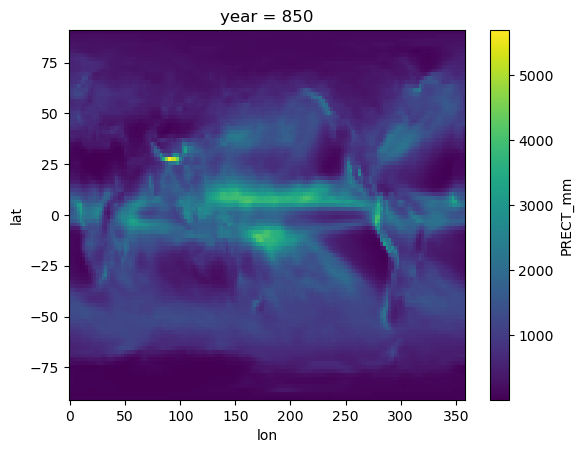

In [39]:
cesmlme_annual_cntl.PRECT_mm[0,:,:].plot()

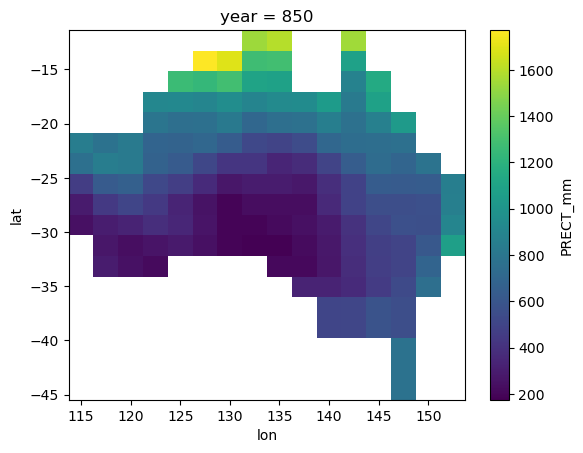

In [38]:
cesmlme_annual_cntl_aus.PRECT_mm[0,:,:].plot()

In [27]:
giss_3_annual_cntl_aus = get_aus(giss_3_annual_cntl)        
giss_1_annual_cntl_aus = get_aus(giss_1_annual_cntl)        
giss_41_annual_cntl_aus = get_aus(giss_41_annual_cntl)        

In [40]:
save_netcdf_compression(bcc_annual_cntl_aus, output_dir, 'bcc_precip_cntl_annual_aus')
save_netcdf_compression(ccsm4_annual_cntl_aus, output_dir, 'ccsm4_precip_cntl_annual_aus')
save_netcdf_compression(csiro_mk3l_annual_cntl_aus, output_dir, 'csiro_mk3l_precip_cntl_annual_aus')
save_netcdf_compression(fgoals_s2_annual_cntl_aus, output_dir, 'fgoals_s2_precip_cntl_annual_aus')
save_netcdf_compression(giss_2_annual_cntl_aus, output_dir, 'giss_2_precip_cntl_annual_aus')
save_netcdf_compression(hadcm3_annual_cntl_aus, output_dir, 'hadcm3_precip_cntl_annual_aus')
save_netcdf_compression(ipsl_annual_cntl_aus, output_dir, 'ipsl_precip_cntl_annual_aus')
save_netcdf_compression(miroc_annaul_cntl_aus, output_dir, 'miroc_precip_cntl_annual_aus')
save_netcdf_compression(mpi_annual_cntl_aus, output_dir, 'mpi_precip_cntl_annual_aus')
save_netcdf_compression(mri_annual_cntl_aus, output_dir, 'mri_precip_cntl_annual_aus')

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


In [28]:
save_netcdf_compression(giss_3_annual_cntl_aus, output_dir, 'giss_3_precip_cntl_annual_aus')
save_netcdf_compression(giss_1_annual_cntl_aus, output_dir, 'giss_1_precip_cntl_annual_aus')
save_netcdf_compression(giss_41_annual_cntl_aus, output_dir, 'giss_41_precip_cntl_annual_aus')

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


import aus files

In [41]:
# output_dir = 'proc_control'

# bcc_annual_cntl_aus = xr.open_dataset('%s/bcc_precip_cntl_annual_aus.nc' % output_dir)
# ccsm4_annual_cntl_aus  = xr.open_dataset('%s/ccsm4_precip_cntl_annual_aus.nc' % output_dir)
# csiro_mk3l_annual_cntl_aus  = xr.open_dataset('%s/csiro_mk3l_precip_cntl_annual_aus.nc' % output_dir)
# fgoals_s2_annual_cntl_aus = xr.open_dataset('%s/fgoals_s2_precip_cntl_annual_aus.nc' % output_dir)
# giss_2_annual_cntl_aus = xr.open_dataset('%s/giss_2_precip_cntl_annual_aus.nc' % output_dir)
# giss_3_annual_cntl_aus = xr.open_dataset('%s/giss_3_precip_cntl_annual_aus.nc' % output_dir)
# hadcm3_annual_cntl_aus = xr.open_dataset('%s/hadcm3_precip_cntl_annual_aus.nc' % output_dir)
# ipsl_annual_cntl_aus = xr.open_dataset('%s/ipsl_precip_cntl_annual_aus.nc' % output_dir)
# miroc_annaul_cntl_aus = xr.open_dataset('%s/miroc_precip_cntl_annual_aus.nc' % output_dir)
# mpi_annual_cntl_aus = xr.open_dataset('%s/mpi_precip_cntl_annual_aus.nc' % output_dir)
# mri_annual_cntl_aus = xr.open_dataset('%s/mri_precip_cntl_annual_aus.nc' % output_dir)
# cesmlme_annual_cntl_aus = xr.open_dataset('%s/cesmlme_precip_cntl_annual_aus.nc' % output_dir)



---
# Regrid files

We need to regrid the global files first, and then subset to Australia. Otherwise Tasmania will be missing and no one wants that.

In [3]:
def regrid_files(ds):
    # resolution of output 3°?
    #[110, 156, -45, -4
#     ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 92, 2.5)),
#                          'lon': (['lon'], np.arange(0, 360, 2.5))})
    ds_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 92, 2)),
                         'lon': (['lon'], np.arange(0, 360, 2))})
    
    regridder = xe.Regridder(ds, ds_out, 'bilinear', periodic=False)
#     regridder = xe.Regridder(ds, ds_out, 'bilinear')


    # regridder.clean_weight_file()
    
    ds_out = regridder(ds)
#     for k in ds.data_vars:
#         print(k, ds_out[k].equals(regridder(ds[k])))
        
    return ds_out

Import global files

In [5]:
cntl_dir = '../files/control'

In [7]:
cesmlme_cntl = xr.open_dataset('%s/%s' % (cntl_dir, 'cesmlme_precip_cntl_annual.nc'))
bcc_cntl = xr.open_dataset('%s/%s' % (cntl_dir, 'bcc_precip_cntl_annual.nc'))
ccsm4_cntl  = xr.open_dataset('%s/%s' % (cntl_dir, 'ccsm4_precip_cntl_annual.nc'))
csiro_mk3l_cntl = xr.open_dataset('%s/%s' % (cntl_dir, 'csiro_mk3l_precip_cntl_annual.nc'))
fgoals_s2_cntl = xr.open_dataset('%s/%s' % (cntl_dir, 'fgoals_s2_precip_cntl_annual.nc'))
giss_2_cntl = xr.open_dataset('%s/%s' % (cntl_dir, 'giss_2_precip_cntl_annual.nc'))
giss_1_cntl = xr.open_dataset('%s/%s' % (cntl_dir, 'giss_1_precip_cntl_annual.nc'))
giss_3_cntl = xr.open_dataset('%s/%s' % (cntl_dir, 'giss_3_precip_cntl_annual.nc'))
giss_41_cntl = xr.open_dataset('%s/%s' % (cntl_dir, 'giss_41_precip_cntl_annual.nc'))
hadmc3_cntl = xr.open_dataset('%s/%s' % (cntl_dir, 'hadcm3_precip_cntl_annual.nc'))
ipsl_cntl = xr.open_dataset('%s/%s' % (cntl_dir, 'ipsl_precip_cntl_annual.nc'))
miroc_cntl = xr.open_dataset('%s/%s' % (cntl_dir, 'miroc_precip_cntl_annual.nc'))
mpi_cntl = xr.open_dataset('%s/%s' % (cntl_dir, 'mpi_precip_cntl_annual.nc'))
mri_cntl = xr.open_dataset('%s/%s' % (cntl_dir, 'mri_precip_cntl_annual.nc'))

Remove uneeded bounds..

In [11]:
bcc_cntl = bcc_cntl.drop(('lat_bnds', 'lon_bnds'))
ccsm4_cntl = ccsm4_cntl.drop(('lat_bnds', 'lon_bnds'))
csiro_mk3l_cntl = csiro_mk3l_cntl.drop(('lat_bnds', 'lon_bnds'))
fgoals_s2_cntl = fgoals_s2_cntl.drop(('lat_bnds', 'lon_bnds'))
giss_2_cntl = giss_2_cntl.drop(('lat_bnds', 'lon_bnds'))
hadmc3_cntl = hadmc3_cntl.drop(('lat_bnds', 'lon_bnds'))
ipsl_cntl = ipsl_cntl.drop(('lat_bnds', 'lon_bnds'))
miroc_cntl = miroc_cntl.drop(('lat_bnds', 'lon_bnds'))
mpi_cntl = mpi_cntl.drop(('lat_bnds', 'lon_bnds', 'time_bnds'))
mri_cntl = mri_cntl.drop(('lat_bnds', 'lon_bnds'))

In [12]:
giss_3_cntl = giss_3_cntl.drop(('lat_bnds', 'lon_bnds'))
giss_1_cntl = giss_1_cntl.drop(('lat_bnds', 'lon_bnds'))
# giss_41_cntl = giss_41_annual_cntl_aus.drop(('lat_bnds', 'lon_bnds'))

Regrid files

In [13]:
giss_3_cntl_rg = regrid_files(giss_3_cntl)
giss_41_cntl_rg = regrid_files(giss_41_cntl)
giss_1_cntl_rg = regrid_files(giss_1_cntl)

In [15]:
cesmlme_cntl_rg = regrid_files(cesmlme_cntl)
bcc_cntl_rg     = regrid_files(bcc_cntl)
ccsm4_cntl_rg   = regrid_files(ccsm4_cntl)
csiro_mk3l_cntl_rg = regrid_files(csiro_mk3l_cntl)
fgoals_s2_cntl_rg = regrid_files(fgoals_s2_cntl)
giss_21_cntl_rg = regrid_files(giss_2_cntl)
hadmc3_cntl_rg = regrid_files(hadmc3_cntl)
ipsl_cntl_rg = regrid_files(ipsl_cntl)
miroc_cntl_rg = regrid_files(miroc_cntl)
mpi_cntl_rg = regrid_files(mpi_cntl)
mri_cntl_rg = regrid_files(mri_cntl)

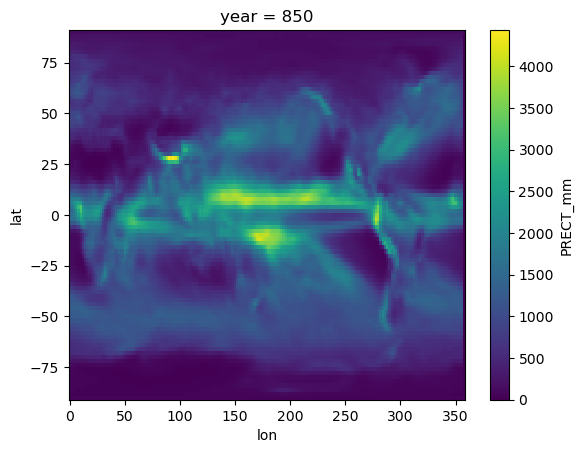

In [17]:
cesmlme_cntl_rg.PRECT_mm[0,:,:].plot()

save regridded files

In [18]:
output_dir_rg = '../files/control_rg'
if not os.path.exists(output_dir_rg):
    os.mkdir(output_dir_rg)

In [ ]:
# DON'T SAVE THEM THIS WAY. THEY TAKE UP WAY TOO MUCH SPACE!

# cesmlme_cntl_rg.to_netcdf('cesmlme_cntl_rg.nc')
# bcc_cntl_rg.to_netcdf('bcc_cntl_rg.nc')
# ccsm4_cntl_rg.to_netcdf('ccsm4_cntl_rg.nc')
# csiro_mk3l_cntl_rg.to_netcdf('csiro_mk3l_cntl_rg.nc')
# fgoals_s2_cntl_rg.to_netcdf('fgoals_s2_cntl_rg.nc')
# giss_21_cntl_rg.to_netcdf('giss_21_cntl_rg.nc')
# hadmc3_cntl_rg.to_netcdf('hadmc3_cntl_rg.nc')
# ipsl_cntl_rg.to_netcdf('ipsl_cntl_rg.nc')
# miroc_cntl_rg.to_netcdf('miroc_cntl_rg.nc')
# mpi_cntl_rg.to_netcdf('mpi_cntl_rg.nc')
# mri_cntl_rg.to_netcdf('mri_cntl_rg.nc')

In [20]:
save_netcdf_compression(giss_3_cntl_rg, output_dir_rg, 'giss_3_precip_cntl_annual_rg')
save_netcdf_compression(giss_1_cntl_rg, output_dir_rg, 'giss_1_precip_cntl_annual_rg')
save_netcdf_compression(giss_41_cntl_rg, output_dir_rg, 'giss_41_precip_cntl_annual_rg')

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


In [33]:
save_netcdf_compression(cesmlme_cntl_rg, output_dir_rg, 'cesmlme_precip_cntl_annual_rg')
save_netcdf_compression(bcc_cntl_rg, output_dir_rg, 'bcc_precip_cntl_annual_rg')
save_netcdf_compression(ccsm4_cntl_rg, output_dir_rg, 'ccsm4_precip_cntl_annual_rg')
save_netcdf_compression(csiro_mk3l_cntl_rg, output_dir_rg, 'csiro_mk3l_precip_cntl_annual_rg')
save_netcdf_compression(fgoals_s2_cntl_rg, output_dir_rg, 'fgoals_s2_precip_cntl_annual_rg')
save_netcdf_compression(giss_21_cntl_rg, output_dir_rg, 'giss_2_precip_cntl_annual_rg')
save_netcdf_compression(hadmc3_cntl_rg, output_dir_rg, 'hadcm3_precip_cntl_annual_rg')
save_netcdf_compression(ipsl_cntl_rg, output_dir_rg, 'ipsl_precip_cntl_annual_rg')
save_netcdf_compression(miroc_cntl_rg, output_dir_rg, 'miroc_precip_cntl_annual_rg')
save_netcdf_compression(mpi_cntl_rg, output_dir_rg, 'mpi_precip_cntl_annual_rg')
save_netcdf_compression(mri_cntl_rg, output_dir_rg, 'mri_precip_cntl_annual_rg')

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


## Subset to Aus

In [24]:
cesmlme_cntl_rg_aus = get_aus(cesmlme_cntl_rg)
bcc_annual_cntl_aus = get_aus(bcc_cntl_rg)              
ccsm4_annual_cntl_aus = get_aus(ccsm4_cntl_rg)          
csiro_mk3l_annual_cntl_aus = get_aus(csiro_mk3l_cntl_rg)
fgoals_s2_annual_cntl_aus = get_aus(fgoals_s2_cntl_rg)  
giss_2_annual_cntl_aus = get_aus(giss_21_cntl_rg)        
hadcm3_annual_cntl_aus = get_aus(hadmc3_cntl_rg)        
ipsl_annual_cntl_aus = get_aus(ipsl_cntl_rg)            
miroc_annaul_cntl_aus = get_aus(miroc_cntl_rg)          
mpi_annual_cntl_aus = get_aus(mpi_cntl_rg)              
mri_annual_cntl_aus = get_aus(mri_cntl_rg)   
giss_1_annual_cntl_aus = get_aus(giss_1_cntl_rg)   
giss_3_annual_cntl_aus = get_aus(giss_3_cntl_rg)
giss_41_annual_cntl_aus = get_aus(giss_41_cntl_rg)

In [25]:
output_dir_rg_aus = '../files/control_rg_aus'
if not os.path.exists(output_dir_rg_aus):
    os.mkdir(output_dir_rg_aus)

In [32]:
save_netcdf_compression(giss_3_annual_cntl_aus, output_dir_rg_aus, 'giss_3_precip_cntl_annual_aus_2d')
save_netcdf_compression(giss_1_annual_cntl_aus, output_dir_rg_aus, 'giss_1_precip_cntl_annual_aus_2d')
save_netcdf_compression(giss_41_annual_cntl_aus, output_dir_rg_aus, 'giss_41_precip_cntl_annual_aus_2d')
save_netcdf_compression(cesmlme_cntl_rg_aus, output_dir_rg_aus, 'cesmlme_precip_cntl_annual_aus_2d')
save_netcdf_compression(bcc_annual_cntl_aus, output_dir_rg_aus, 'bcc_precip_cntl_annual_aus_2d')
save_netcdf_compression(ccsm4_annual_cntl_aus, output_dir_rg_aus, 'ccsm4_precip_cntl_annual_aus_2d')
save_netcdf_compression(csiro_mk3l_annual_cntl_aus, output_dir_rg_aus, 'csiro_mk3l_precip_cntl_annual_aus_2d')
save_netcdf_compression(fgoals_s2_annual_cntl_aus, output_dir_rg_aus, 'fgoals_s2_precip_cntl_annual_aus_2d')
save_netcdf_compression(giss_2_annual_cntl_aus, output_dir_rg_aus, 'giss_2_precip_cntl_annual_aus_2d')
save_netcdf_compression(hadcm3_annual_cntl_aus, output_dir_rg_aus, 'hadcm3_precip_cntl_annual_rg')
save_netcdf_compression(ipsl_annual_cntl_aus, output_dir_rg_aus, 'ipsl_precip_cntl_annual_aus_2d')
save_netcdf_compression(miroc_annaul_cntl_aus, output_dir_rg_aus, 'miroc_precip_cntl_annual_aus_2d')
save_netcdf_compression(mpi_annual_cntl_aus, output_dir_rg_aus, 'mpi_precip_cntl_annual_aus_2d')
save_netcdf_compression(mri_annual_cntl_aus, output_dir_rg_aus, 'mri_precip_cntl_annual_aus_2d')

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


In [80]:
bcc_annual_cntl_eastern_aus_rc = droughts_metrics_timeseries(bcc_annual_cntl_eastern_aus)
ccsm4_annual_cntl_eastern_aus_rc = droughts_metrics_timeseries(ccsm4_annual_cntl_eastern_aus)
csiro_mk3l_annual_cntl_eastern_aus_rc = droughts_metrics_timeseries(csiro_mk3l_annual_cntl_eastern_aus)
fgoals_s2_annual_cntl_eastern_aus_rc = droughts_metrics_timeseries(fgoals_s2_annual_cntl_eastern_aus)
giss_2_annual_cntl_eastern_aus_rc = droughts_metrics_timeseries(giss_2_annual_cntl_eastern_aus)
giss_3_annual_cntl_eastern_aus_rc = droughts_metrics_timeseries(giss_3_annual_cntl_eastern_aus)
hadcm3_annual_cntl_eastern_aus_rc = droughts_metrics_timeseries(hadcm3_annual_cntl_eastern_aus)
ipsl_annual_cntl_eastern_aus_rc = droughts_metrics_timeseries(ipsl_annual_cntl_eastern_aus)
miroc_annual_cntl_eastern_aus_rc = droughts_metrics_timeseries(miroc_annual_cntl_eastern_aus)
mpi_annual_cntl_eastern_aus_rc = droughts_metrics_timeseries(mpi_annual_cntl_eastern_aus)
mri_annual_cntl_eastern_aus_rc = droughts_metrics_timeseries(mri_annual_cntl_eastern_aus)
cesmlme_annual_cntl_eastern_aus_rc = droughts_metrics_timeseries(cesmlme_annual_cntl_eastern_aus)


In [81]:
save_netcdf_compression(bcc_annual_cntl_eastern_aus_rc, output_dir, 'bcc_precip_cntl_annual_eastern_aus')
save_netcdf_compression(ccsm4_annual_cntl_eastern_aus_rc, output_dir, 'ccsm4_precip_cntl_annual_eastern_aus')
save_netcdf_compression(csiro_mk3l_annual_cntl_eastern_aus_rc, output_dir, 'csiro_mk3l_precip_cntl_annual_eastern_aus')
save_netcdf_compression(fgoals_s2_annual_cntl_eastern_aus_rc, output_dir, 'fgoals_s2_precip_cntl_annual_eastern_aus')
save_netcdf_compression(giss_2_annual_cntl_eastern_aus_rc, output_dir, 'giss_2_precip_cntl_annual_eastern_aus')
save_netcdf_compression(giss_3_annual_cntl_eastern_aus_rc, output_dir, 'giss_3_precip_cntl_annual_eastern_aus')
save_netcdf_compression(hadcm3_annual_cntl_eastern_aus_rc, output_dir, 'hadcm3_precip_cntl_annual_eastern_aus')
save_netcdf_compression(ipsl_annual_cntl_eastern_aus_rc, output_dir, 'ipsl_precip_cntl_annual_eastern_aus')
save_netcdf_compression(miroc_annual_cntl_eastern_aus_rc, output_dir, 'miroc_precip_cntl_annual_eastern_aus')
save_netcdf_compression(mpi_annual_cntl_eastern_aus_rc, output_dir, 'mpi_precip_cntl_annual_eastern_aus')
save_netcdf_compression(mri_annual_cntl_eastern_aus_rc, output_dir, 'mri_precip_cntl_annual_eastern_aus')

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


In [11]:
cesmlme_annual_cntl_eastern_aus = get_eastern_aus_mean(cesmlme_annual_cntl_aus)
cesmlme_annual_cntl_eastern_aus_rc = droughts_metrics_timeseries(cesmlme_annual_cntl_eastern_aus)
save_netcdf_compression(cesmlme_annual_cntl_eastern_aus_rc, output_dir, 'cesmlme_precip_cntl_annual_eastern_aus')



[########################################] | 100% Completed |  0.1s


## murray darling basin

In [41]:
def get_mdb_mean(ds):
    # import shapefile using geopandas
    states = gp.read_file('/Users/nickywright/Data/Coastlines/Murray.shp')
    mask = regionmask.mask_geopandas(states, ds.lon, ds.lat)
    # mask out 
    ds_mdb = ds.where(mask == mask, drop=True)
    ds_mdb_mean = climate_xr_funcs.weighted_mean_CAM(ds_mdb)
    
    return ds_mdb_mean

In [42]:
bcc_annual_cntl_mdb = get_mdb_mean(bcc_annual_cntl_aus)              
ccsm4_annual_cntl_mdb = get_mdb_mean(ccsm4_annual_cntl_aus)          
csiro_mk3l_annual_cntl_mdb = get_mdb_mean(csiro_mk3l_annual_cntl_aus)
fgoals_s2_annual_cntl_mdb = get_mdb_mean(fgoals_s2_annual_cntl_aus)  
giss_2_annual_cntl_mdb = get_mdb_mean(giss_2_annual_cntl_aus)        
giss_3_annual_cntl_mdb = get_mdb_mean(giss_3_annual_cntl_aus)        
hadcm3_annual_cntl_mdb = get_mdb_mean(hadcm3_annual_cntl_aus)        
ipsl_annual_cntl_mdb = get_mdb_mean(ipsl_annual_cntl_aus)            
miroc_annual_cntl_mdb = get_mdb_mean(miroc_annaul_cntl_aus)          
mpi_annual_cntl_mdb = get_mdb_mean(mpi_annual_cntl_aus)              
mri_annual_cntl_mdb = get_mdb_mean(mri_annual_cntl_aus)
cesmlme_annual_cntl_mdb = get_mdb_mean(cesmlme_annual_cntl_aus)




In [46]:
bcc_annual_cntl_mdb_rc = droughts_metrics_timeseries(bcc_annual_cntl_mdb)
ccsm4_annual_cntl_mdb_rc = droughts_metrics_timeseries(ccsm4_annual_cntl_mdb)
csiro_mk3l_annual_cntl_mdb_rc = droughts_metrics_timeseries(csiro_mk3l_annual_cntl_mdb)
fgoals_s2_annual_cntl_mdb_rc = droughts_metrics_timeseries(fgoals_s2_annual_cntl_mdb)
giss_2_annual_cntl_mdb_rc = droughts_metrics_timeseries(giss_2_annual_cntl_mdb)
giss_3_annual_cntl_mdb_rc = droughts_metrics_timeseries(giss_3_annual_cntl_mdb)
hadcm3_annual_cntl_mdb_rc = droughts_metrics_timeseries(hadcm3_annual_cntl_mdb)
ipsl_annual_cntl_mdb_rc = droughts_metrics_timeseries(ipsl_annual_cntl_mdb)
miroc_annual_cntl_mdb_rc = droughts_metrics_timeseries(miroc_annual_cntl_mdb)
mpi_annual_cntl_mdb_rc = droughts_metrics_timeseries(mpi_annual_cntl_mdb)
mri_annual_cntl_mdb_rc = droughts_metrics_timeseries(mri_annual_cntl_mdb)
cesmlme_annual_cntl_mdb_rc = droughts_metrics_timeseries(cesmlme_annual_cntl_mdb)




In [47]:
save_netcdf_compression(bcc_annual_cntl_mdb_rc, output_dir, 'bcc_precip_cntl_annual_mdb')
save_netcdf_compression(ccsm4_annual_cntl_mdb_rc, output_dir, 'ccsm4_precip_cntl_annual_mdb')
save_netcdf_compression(csiro_mk3l_annual_cntl_mdb_rc, output_dir, 'csiro_mk3l_precip_cntl_annual_mdb')
save_netcdf_compression(fgoals_s2_annual_cntl_mdb_rc, output_dir, 'fgoals_s2_precip_cntl_annual_mdb')
save_netcdf_compression(giss_2_annual_cntl_mdb_rc, output_dir, 'giss_2_precip_cntl_annual_mdb')
save_netcdf_compression(giss_3_annual_cntl_mdb_rc, output_dir, 'giss_3_precip_cntl_annual_mdb')
save_netcdf_compression(hadcm3_annual_cntl_mdb_rc, output_dir, 'hadcm3_precip_cntl_annual_mdb')
save_netcdf_compression(ipsl_annual_cntl_mdb_rc, output_dir, 'ipsl_precip_cntl_annual_mdb')
save_netcdf_compression(miroc_annual_cntl_mdb_rc, output_dir, 'miroc_precip_cntl_annual_mdb')
save_netcdf_compression(mpi_annual_cntl_mdb_rc, output_dir, 'mpi_precip_cntl_annual_mdb')
save_netcdf_compression(mri_annual_cntl_mdb_rc, output_dir, 'mri_precip_cntl_annual_mdb')
save_netcdf_compression(cesmlme_annual_cntl_mdb_rc, output_dir, 'cesmlme_precip_cntl_annual_mdb')

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
